# Getting started

For this first example, we already have loaded a pre-trained LeNet5 model
to look at explanations on the MNIST dataset.

In [1]:
using Flux

using BSON # hide
model = BSON.load("../model.bson", @__MODULE__)[:model] # hide
model

Chain(
  Conv((5, 5), 1 => 6, relu),           # 156 parameters
  MaxPool((2, 2)),
  Conv((5, 5), 6 => 16, relu),          # 2_416 parameters
  MaxPool((2, 2)),
  Flux.flatten,
  Dense(256 => 120, relu),              # 30_840 parameters
  Dense(120 => 84, relu),               # 10_164 parameters
  Dense(84 => 10),                      # 850 parameters
)                   # Total: 10 arrays, 44_426 parameters, 174.344 KiB.

## Preparing the input data
We use MLDatasets to load a single image from the MNIST dataset:

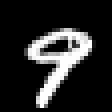

In [2]:
using MLDatasets
using ImageCore, ImageIO, ImageShow

index = 10
x, y = MNIST(Float32, :test)[10]

convert2image(MNIST, x)

By convention in Flux.jl, this input needs to be resized to WHCN format
by adding a color channel and batch dimensions.

In [3]:
input = reshape(x, 28, 28, 1, :);

## Explanations
We can now select an analyzer of our choice and call `analyze` to get an `Explanation`.
Note that for gradient-based optimizers, a backend for automatic differentiation must be loaded, by default [Zygote.jl](https://github.com/FluxML/Zygote.jl):

In [4]:
using ExplainableAI
using Zygote

analyzer = InputTimesGradient(model)
expl = analyze(input, analyzer);

The return value `expl` is of type `Explanation` and bundles the following data:
* `expl.val`: numerical output of the analyzer, e.g. an attribution or gradient
* `expl.output`: model output for the given analyzer input
* `expl.output_selection`: index of the output used for the explanation
* `expl.analyzer`: symbol corresponding the used analyzer, e.g. `:Gradient` or `:LRP`
* `expl.heatmap`: symbol indicating a preset heatmapping style,
    e.g. `:attibution`, `:sensitivity` or `:cam`
* `expl.extras`: optional named tuple that can be used by analyzers
    to return additional information.

We used `InputTimesGradient`, so `expl.analyzer` is `:InputTimesGradient`.

In [5]:
expl.analyzer

:InputTimesGradient

By default, the explanation is computed for the maximally activated output neuron.
Since our digit is a 9 and Julia's indexing is 1-based,
the output neuron at index `10` of our trained model is maximally activated.

Finally, we obtain the result of the analyzer in form of an array.

In [6]:
expl.val

28×28×1×1 Array{Float32, 4}:
[:, :, 1, 1] =
 -0.0   0.0   0.0  -0.0  -0.0  -0.0  -0.0  …  -0.0       0.0         0.0
 -0.0   0.0   0.0  -0.0  -0.0  -0.0  -0.0     -0.0       0.0         0.0
 -0.0   0.0   0.0  -0.0  -0.0  -0.0  -0.0     -0.0       0.0         0.0
  0.0   0.0   0.0  -0.0  -0.0  -0.0  -0.0      0.0       0.0         0.0
  0.0   0.0  -0.0  -0.0  -0.0   0.0   0.0      0.0       0.0         0.0
 -0.0   0.0   0.0  -0.0   0.0  -0.0  -0.0  …   0.0       0.0         0.0
 -0.0   0.0   0.0   0.0   0.0   0.0   0.0      0.0       0.0         0.0
 -0.0   0.0   0.0   0.0  -0.0   0.0  -0.0      0.0       0.0        -0.0
 -0.0   0.0   0.0   0.0  -0.0  -0.0  -0.0      0.0       0.0        -0.0
 -0.0   0.0   0.0   0.0  -0.0   0.0  -0.0      0.385115  0.0714216   0.0
  ⋮                             ⋮          ⋱   ⋮                    
  0.0  -0.0  -0.0   0.0   0.0   0.0  -0.0     -0.0       0.0         0.0
 -0.0  -0.0   0.0   0.0   0.0   0.0  -0.0  …  -0.0       0.0         0.0
 -0.0   0.0

## Heatmapping basics
Since the array `expl.val` is not very informative at first sight,
we can visualize `Explanation`s by computing a `heatmap` using either
[VisionHeatmaps.jl](https://julia-xai.github.io/XAIDocs/VisionHeatmaps/stable/) or
[TextHeatmaps.jl](https://julia-xai.github.io/XAIDocs/TextHeatmaps/stable/).

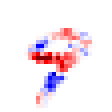

In [7]:
using VisionHeatmaps

heatmap(expl)

If we are only interested in the heatmap, we can combine analysis and heatmapping
into a single function call:

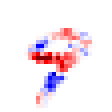

In [8]:
heatmap(input, analyzer)

For a more detailed explanation of the `heatmap` function,
refer to the heatmapping section.

## List of analyzers

## Neuron selection
By passing an additional index to our call to `analyze`,
we can compute an explanation with respect to a specific output neuron.
Let's see why the output wasn't interpreted as a 4 (output neuron at index 5)

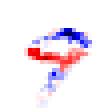

In [9]:
expl = analyze(input, analyzer, 5)
heatmap(expl)

This heatmap shows us that the "upper loop" of the hand-drawn 9 has negative relevance
with respect to the output neuron corresponding to digit 4!

## Analyzing batches
ExplainableAI also supports explanations of input batches:

In [10]:
batchsize = 20
xs, _ = MNIST(Float32, :test)[1:batchsize]
batch = reshape(xs, 28, 28, 1, :) # reshape to WHCN format
expl = analyze(batch, analyzer);

This will return a single `Explanation` `expl` for the entire batch.
Calling `heatmap` on `expl` will detect the batch dimension and return a vector of heatmaps.

,,,,,,,,,,,,,,,,,,,

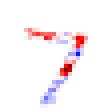
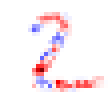
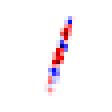
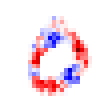
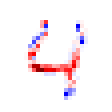
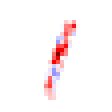
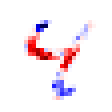
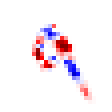
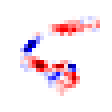
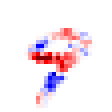
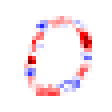
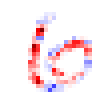
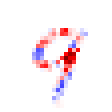
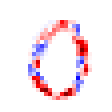
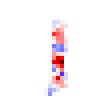
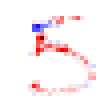
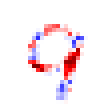
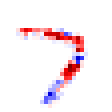
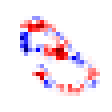
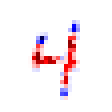

In [11]:
heatmap(expl)

For more information on heatmapping batches,
refer to the heatmapping documentation.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*